In [1]:
!pip install git+https://github.com/imanring/BSTPP.git

  Cloning https://github.com/imanring/BSTPP.git to /tmp/pip-req-build-8fn6ork4
  Running command git clone --filter=blob:none --quiet https://github.com/imanring/BSTPP.git /tmp/pip-req-build-8fn6ork4
  Resolved https://github.com/imanring/BSTPP.git to commit 54ac69a7a37699f164584f3761973062fc9e7653
  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for BSTPP, since package 'wheel' is not installed.
  Running setup.py install for BSTPP ... done


In [1]:
from bstpp.main import Point_Process_Model
import numpyro.distributions as dist
import numpy as np

In [2]:
A = np.array([[3,15.5],[4,16.5]])
column_names = ['droughtstart_speibase', 'urban_ih_log', 'droughtyr_speigdm',
       'herb_gc', 'capdist', 'grass_ih_log', 'nlights_sd_log', 'water_gc_log',
       'pop_gpw_sd_log', 'pasture_ih']
model_name = 'cox_hawkes'
model = Point_Process_Model('data/spt_data.csv',A,model=model_name,
                            spatial_cov='data/spatial_cov.csv',cov_grid_size=(0.5,0.5),
                            cov_names = column_names,
                            a_0=dist.Normal(0,5)
                           )

/home/imanring/PointProcess/Cox_Hawkes_Cov/bstpp/main.py:169: UserWarning: `keep_geom_type=True` in overlay resulted in 4573 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersect = gpd.overlay(comp_grid, spatial_cov, how='intersection')


In [ ]:
import sys
from bstpp import inference_functions
from bstpp import utils
sys.modules['inference_functions'] = inference_functions
sys.modules['utils'] = utils

import pickle
pre_run = False
if pre_run:
    with open(f'output/{model_name}/output.pkl', 'rb') as f:
        output = pickle.load(f)
    model.mcmc = output['mcmc']
    model.mcmc_samples = output['samples']
else:
    model.run_mcmc(num_warmup=500,num_samples=1000,output_file=f'output/{model_name}/output.pkl')

warmup:  26%|██████▋                   | 386/1500 [39:34<1:44:09,  5.61s/it, 127 steps of size 4.94e-02. acc. prob=0.78]

In [4]:
model.args['cov_ind'],model.args['indices_xy']

(array([395, 395, 395, ..., 521, 317, 472]),
 array([395, 395, 395, ..., 521, 317, 472]))

In [6]:
str(model.spatial_cov.loc[395,'geometry'])

'POLYGON ((13 11.5, 13.5 11.5, 13.5 12, 13 12, 13 11.5))'

In [7]:
str(model.comp_grid.loc[395,'geometry'])

'POLYGON ((13 11.5, 13.500000000000002 11.5, 13.500000000000002 12, 13 12, 13 11.5))'

In [24]:
n_xy = 25
grid = np.arange(0, 1, 1/n_xy)
u, v = np.meshgrid(grid, grid)
x_xy = np.array([u.flatten(), v.flatten()]).transpose((1, 0))
x_xy[472]*12.5+np.array([3,4])

array([14., 13.])

In [44]:
np.exp(model.mcmc_samples['b_0'][0]+model.mcmc_samples['f_xy'][0]).sum()/625

642.8262

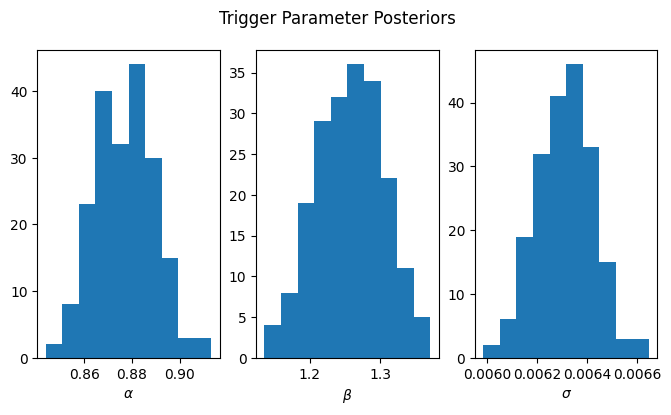

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
alpha,0.877317,0.012366,70.947517,0.0,0.855418,0.901418
beta,1.257941,0.048159,26.120556,0.0,1.165985,1.342835
sigma,0.006311,0.000112,56.222347,0.0,0.006104,0.006526


In [4]:
model.plot_trigger_posterior(f'output/{model_name}/trig_post.png')

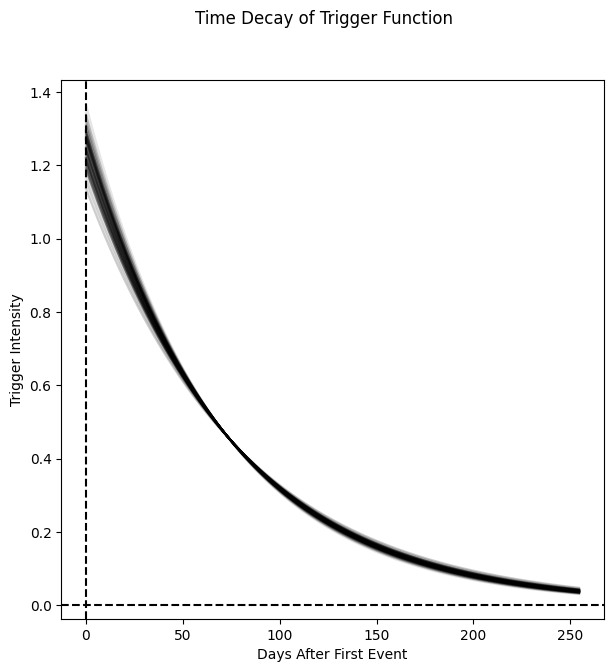

Mean trigger time: 72.72 days


In [5]:
model.plot_trigger_time_decay(f'output/{model_name}/trig_post_time_decay.png')

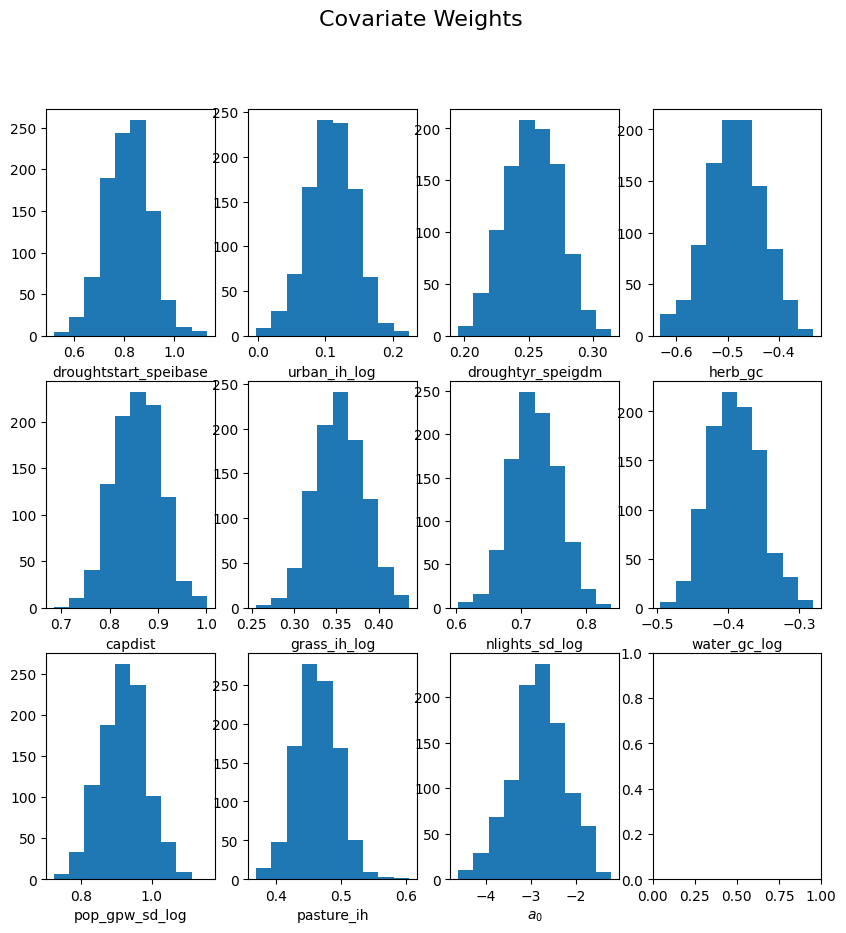

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
droughtstart_speibase,0.815183,0.088156,9.247035,0.000000,0.639484,0.976734
urban_ih_log,0.108593,0.035454,3.062959,0.002192,0.035948,0.174403
droughtyr_speigdm,0.253357,0.020618,12.288250,0.000000,0.213680,0.292766
herb_gc,-0.485531,0.053740,-9.034755,0.000000,-0.596448,-0.384980
capdist,0.857503,0.048603,17.642893,0.000000,0.764679,0.950300
grass_ih_log,0.353910,0.029420,12.029415,0.000000,0.296134,0.414721
nlights_sd_log,0.721092,0.036313,19.857666,0.000000,0.652651,0.791987
water_gc_log,-0.390504,0.036385,-10.732503,0.000000,-0.454475,-0.316167
pop_gpw_sd_log,0.920837,0.064950,14.177656,0.000000,0.791133,1.049897
pasture_ih,0.463416,0.032215,14.385299,0.000000,0.402995,0.527089


In [8]:
model.cov_weight_post_summary(plot_file=f'output/{model_name}/cov_post_hist.png',
                              summary_file=f'output/{model_name}/cov_par_summary.csv')

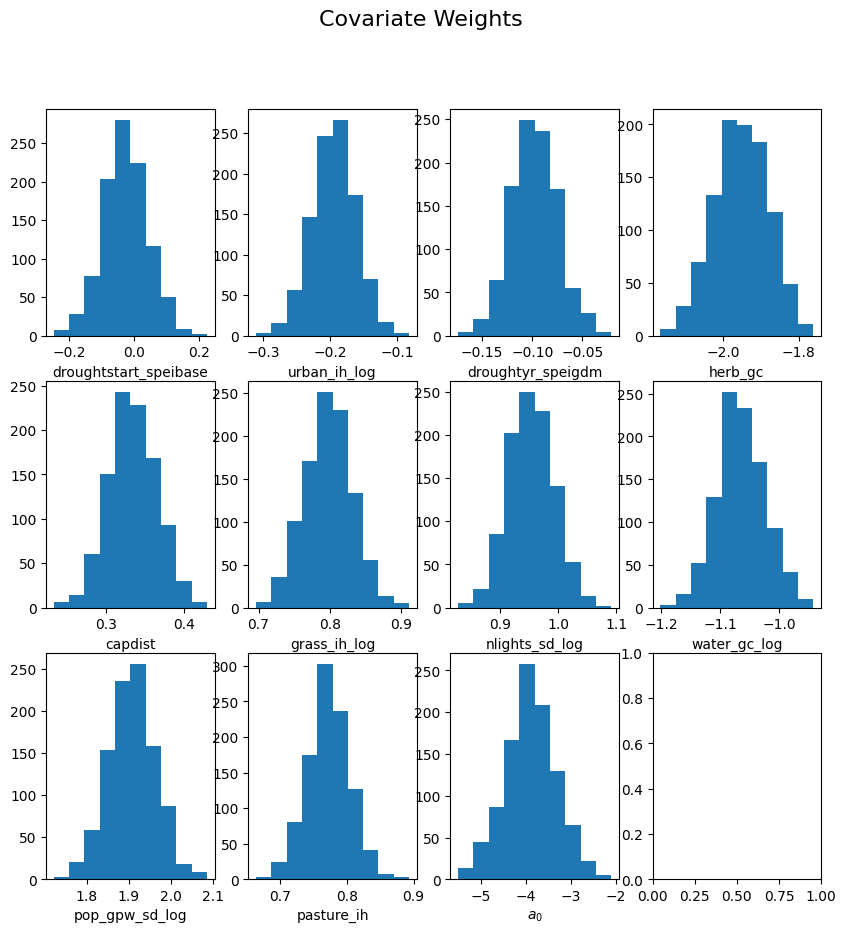

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
droughtstart_speibase,-0.026410,0.068199,-0.387246,6.985744e-01,-0.163053,0.108921
urban_ih_log,-0.194127,0.033474,-5.799397,6.655384e-09,-0.261655,-0.131205
droughtyr_speigdm,-0.097701,0.023153,-4.219740,2.445837e-05,-0.142952,-0.050939
herb_gc,-1.951419,0.071800,-27.178684,0.000000e+00,-2.091762,-1.814977
capdist,0.334523,0.030745,10.880453,0.000000e+00,0.274828,0.396215
grass_ih_log,0.798214,0.033543,23.796389,0.000000e+00,0.733246,0.864614
nlights_sd_log,0.954065,0.038437,24.821726,0.000000e+00,0.881165,1.032320
water_gc_log,-1.065019,0.041440,-25.699984,0.000000e+00,-1.144662,-0.975849
pop_gpw_sd_log,1.907694,0.056164,33.966259,0.000000e+00,1.798809,2.015965
pasture_ih,0.772909,0.032189,24.011225,0.000000e+00,0.709884,0.837579


In [10]:
model.cov_weight_post_summary(plot_file=f'output/{model_name}/cov_post_hist.png',
                              summary_file=f'output/{model_name}/cov_par_summary.csv')

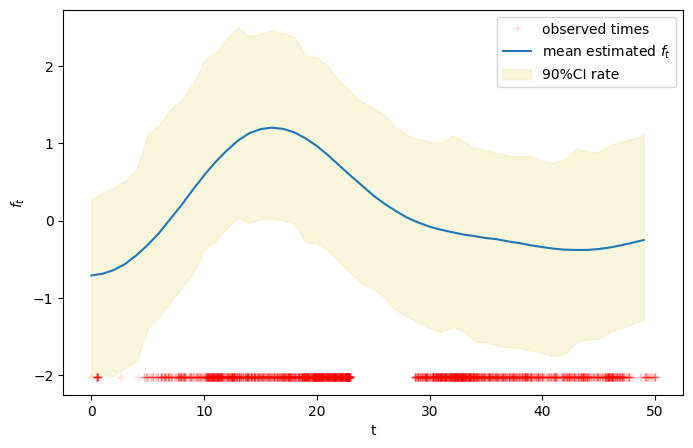

In [7]:
model.plot_temporal_background(f'output/{model_name}/temporal_gp_post_mean.png')

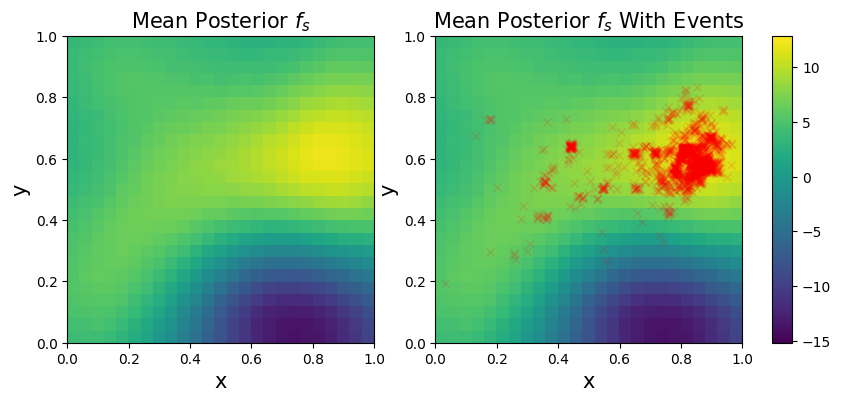

In [5]:
model.plot_spatial_background(f'output/{model_name}/spatial_gp_post_mean.png')

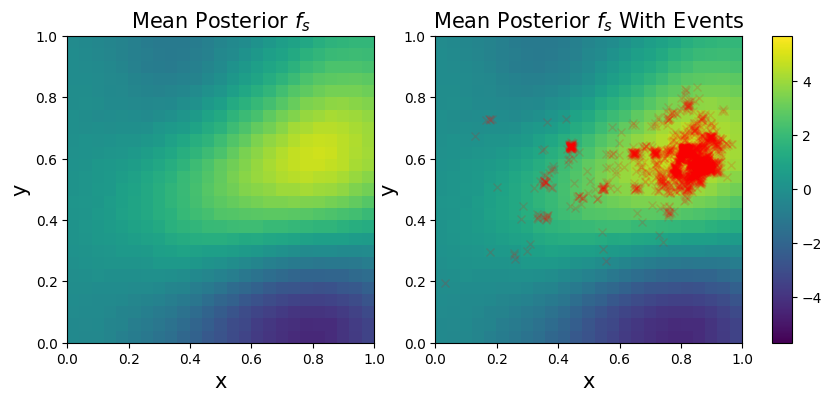

In [8]:
model.plot_spatial_background(f'output/{model_name}/spatial_gp_post_mean.png')

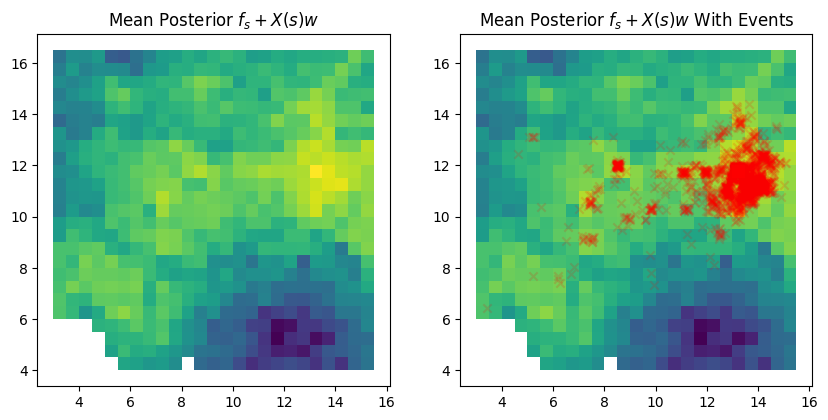

In [4]:
model.plot_spatial_background(f'output/{model_name}/spatial_gp_cov_post_mean.png',include_cov=True)